# Notebook 1: Localización de la región de interés (ROI)

1. Creación del dataset
2. Modelo CNN base + Resnet18
3. Entrenamiento y evaluación del modelo
4. Visualización y análisis de resultados obtenidos

In [1]:
import pandas as pd

import os
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
def establecer_semilla(semilla=42):
    random.seed(semilla)
    np.random.seed(semilla)
    torch.manual_seed(semilla)
    torch.cuda.manual_seed_all(semilla)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Establecemos la semilla
establecer_semilla(42)

## Paso 3. Modelo CNN Base + Resnet18

### Creación del dataset

* Creamos un dataset que proporciona pares (imagen original, máscara ROI) perfectamente sincronizados y redimensionados a 128x128 píxeles.
* Cada imagen original se acompaña de una máscara binaria (ROI) que permitirá entrenar los modelos.
* El DataLoader permite un manejo sencillo y eficiente de datos en batches durante el entrenamiento.

In [3]:
class ROIBBoxDataset(Dataset):
    def __init__(self, df_trazas, path_originales, image_size=(128,128)):
        self.df_trazas = df_trazas.reset_index(drop=True)
        self.path_originales = path_originales
        self.image_size = image_size

    def __len__(self):
        return len(self.df_trazas)

    def __getitem__(self, idx):
        registro = self.df_trazas.iloc[idx]
        ruta_img_original = os.path.join(self.path_originales, registro['forig'])

        # Cargamos la imagen original en gris
        img_original = cv2.imread(ruta_img_original, cv2.IMREAD_GRAYSCALE)
        img_original = cv2.resize(img_original, self.image_size) / 255.0
        img_original = np.expand_dims(img_original, axis=0)

        # Obtenemos bounding box del CSV y la normalizamos
        bbox_str = registro['BB'].replace('[','').replace(']','').split(',')
        x, y, w, h = [float(coord) for coord in bbox_str]

        # Dimensiones originales
        altura_orig, ancho_orig = cv2.imread(ruta_img_original, cv2.IMREAD_GRAYSCALE).shape

        # Normalización de bounding box [0,1]
        x_norm = x / ancho_orig
        y_norm = y / altura_orig
        w_norm = w / ancho_orig
        h_norm = h / altura_orig
        bbox_normalizada = np.array([x_norm, y_norm, w_norm, h_norm])

        return torch.tensor(img_original, dtype=torch.float32), torch.tensor(bbox_normalizada, dtype=torch.float32)

In [4]:
df_trazas_limpio = pd.read_csv("df_trazas_limpio.csv")

df_train, df_temp = train_test_split(
    df_trazas_limpio,
    test_size=0.3,
    random_state=42
)

df_val, df_test = train_test_split(
    df_temp,
    test_size=0.5,
    random_state=42
)

In [5]:
train_dataset = ROIBBoxDataset(df_train, "REY_DATASET/REY_scan_anonim", image_size=(256, 256))
val_dataset   = ROIBBoxDataset(df_val,   "REY_DATASET/REY_scan_anonim", image_size=(256, 256))
test_dataset  = ROIBBoxDataset(df_test,  "REY_DATASET/REY_scan_anonim", image_size=(256, 256))

loader_train = DataLoader(train_dataset, batch_size=16, shuffle=True)
loader_val   = DataLoader(val_dataset, batch_size=16, shuffle=False)
loader_test  = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Implementación de una CNN simplificada en PyTorch

In [6]:
class SimpleBBoxCNN(nn.Module):
    def __init__(self):
        super(SimpleBBoxCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 4), nn.Sigmoid()  # Salida normalizada entre 0 y 1
        )

    def forward(self, x):
        x = self.features(x)
        bbox = self.fc(x)
        return bbox


### Implementación de RESNET18

In [7]:
# Cargamos ResNet18 con pesos preentrenados
weights = ResNet18_Weights.DEFAULT
resnet18 = resnet18(weights=weights)

In [8]:
# Obtenemos el número de features originales (512 en resnet18)
num_features = resnet18.fc.in_features

# Reemplazamos la última capa lineal para nuestra regresión
resnet18.fc = nn.Sequential(
    nn.Linear(num_features, 128), nn.ReLU(),
    nn.Linear(128, 4), nn.Sigmoid()  # salida normalizada entre 0 y 1
)

### Entrenameinto del modelo

Usaremos los siguientes elementos claramente definidos:

* Función de pérdida: BCE Loss (Binary Cross-Entropy), ideal para segmentación binaria.
* Optimizador: Adam (con una tasa de aprendizaje inicial razonable, por ejemplo 1e-3).
* Número de épocas: inicialmente 10 (puede ajustarse posteriormente según resultados observados).

In [9]:
# Dispositivo (GPU si disponible)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


In [10]:
#instancia del modelo simple
modelo_bbox = SimpleBBoxCNN()
criterio_bbox = nn.MSELoss()
optimizador_bbox = optim.Adam(modelo_bbox.parameters(), lr=1e-3)

num_epocas = 30

modelo_bbox = modelo_bbox.to(device)

for epoca in range(num_epocas):
    modelo_bbox.train()
    perdida_epoca_train = 0.0

    for imgs, bboxes in loader_train:
        imgs, bboxes = imgs.to(device), bboxes.to(device)

        optimizador_bbox.zero_grad()
        pred_bboxes = modelo_bbox(imgs)
        perdida = criterio_bbox(pred_bboxes, bboxes)
        perdida.backward()
        optimizador_bbox.step()

        perdida_epoca_train += perdida.item()

    perdida_media_train = perdida_epoca_train / len(loader_train)

    # Validación
    modelo_bbox.eval()
    perdida_epoca_val = 0.0

    with torch.no_grad():
        for imgs, bboxes in loader_val:
            imgs, bboxes = imgs.to(device), bboxes.to(device)

            pred_bboxes = modelo_bbox(imgs)
            perdida = criterio_bbox(pred_bboxes, bboxes)
            perdida_epoca_val += perdida.item()

    perdida_media_val = perdida_epoca_val / len(loader_val)

    print(f"Época [{epoca+1}/{num_epocas}] - Pérdida train: {perdida_media_train:.6f} | val: {perdida_media_val:.6f}")

print("Entrenamiento terminado.")

Época [1/30] - Pérdida train: 0.057632 | val: 0.044265
Época [2/30] - Pérdida train: 0.037899 | val: 0.040338
Época [3/30] - Pérdida train: 0.035635 | val: 0.037641
Época [4/30] - Pérdida train: 0.031642 | val: 0.030911
Época [5/30] - Pérdida train: 0.025801 | val: 0.026012
Época [6/30] - Pérdida train: 0.021196 | val: 0.025145
Época [7/30] - Pérdida train: 0.020579 | val: 0.025320
Época [8/30] - Pérdida train: 0.020925 | val: 0.023722
Época [9/30] - Pérdida train: 0.019900 | val: 0.023157
Época [10/30] - Pérdida train: 0.020731 | val: 0.023800
Época [11/30] - Pérdida train: 0.020587 | val: 0.023201
Época [12/30] - Pérdida train: 0.020159 | val: 0.023332
Época [13/30] - Pérdida train: 0.020623 | val: 0.024301
Época [14/30] - Pérdida train: 0.020506 | val: 0.023440
Época [15/30] - Pérdida train: 0.019871 | val: 0.023197
Época [16/30] - Pérdida train: 0.019899 | val: 0.023291
Época [17/30] - Pérdida train: 0.020370 | val: 0.023423
Época [18/30] - Pérdida train: 0.020414 | val: 0.024008
É

In [11]:
# Selección del dispositivo (MPS, CUDA o CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")

# Modelo al dispositivo
resnet18 = resnet18.to(device)

# Criterio (MSE para regresión)
criterio = nn.MSELoss()

# Optimizador (Adam con lr pequeña por transferencia)
optimizador = torch.optim.Adam(resnet18.parameters(), lr=1e-4)


In [12]:
num_epocas = 30

for epoca in range(num_epocas):
    resnet18.train()
    perdida_epoca_train = 0.0

    for imgs, bboxes in loader_train:
        imgs = imgs.repeat(1, 3, 1, 1).to(device)  # Convertir a RGB
        bboxes = bboxes.to(device)

        optimizador.zero_grad()
        preds = resnet18(imgs)
        perdida = criterio(preds, bboxes)
        perdida.backward()
        optimizador.step()

        perdida_epoca_train += perdida.item()

    perdida_media_train = perdida_epoca_train / len(loader_train)

    # Validación
    resnet18.eval()
    perdida_epoca_val = 0.0

    with torch.no_grad():
        for imgs, bboxes in loader_val:
            imgs = imgs.repeat(1, 3, 1, 1).to(device)
            bboxes = bboxes.to(device)

            preds = resnet18(imgs)
            perdida = criterio(preds, bboxes)
            perdida_epoca_val += perdida.item()

    perdida_media_val = perdida_epoca_val / len(loader_val)

    print(f"Época [{epoca+1}/{num_epocas}] - Pérdida train: {perdida_media_train:.6f} | val: {perdida_media_val:.6f}")

print("Entrenamiento terminado.")



Época [1/30] - Pérdida train: 0.026899 | val: 0.016638
Época [2/30] - Pérdida train: 0.009686 | val: 0.012559
Época [3/30] - Pérdida train: 0.008009 | val: 0.011997
Época [4/30] - Pérdida train: 0.006573 | val: 0.011269
Época [5/30] - Pérdida train: 0.006442 | val: 0.010768
Época [6/30] - Pérdida train: 0.006318 | val: 0.011314
Época [7/30] - Pérdida train: 0.006045 | val: 0.010721
Época [8/30] - Pérdida train: 0.005856 | val: 0.010765
Época [9/30] - Pérdida train: 0.006182 | val: 0.010956
Época [10/30] - Pérdida train: 0.005574 | val: 0.010756
Época [11/30] - Pérdida train: 0.005656 | val: 0.010553
Época [12/30] - Pérdida train: 0.005360 | val: 0.010592
Época [13/30] - Pérdida train: 0.005313 | val: 0.010749
Época [14/30] - Pérdida train: 0.005270 | val: 0.010526
Época [15/30] - Pérdida train: 0.005067 | val: 0.010142
Época [16/30] - Pérdida train: 0.005143 | val: 0.010044
Época [17/30] - Pérdida train: 0.005133 | val: 0.010861
Época [18/30] - Pérdida train: 0.005112 | val: 0.010368
É

### Evaluación visual y cualitativa

In [13]:
def calcular_iou(bbox_real, bbox_pred):
    # bbox: x, y, ancho, alto (desnormalizadas)
    x_real, y_real, w_real, h_real = bbox_real
    x_pred, y_pred, w_pred, h_pred = bbox_pred

    # Coordenadas esquina superior izquierda e inferior derecha
    x1_real, y1_real = x_real, y_real
    x2_real, y2_real = x_real + w_real, y_real + h_real
    x1_pred, y1_pred = x_pred, y_pred
    x2_pred, y2_pred = x_pred + w_pred, y_pred + h_pred

    # Área de intersección
    inter_x1 = max(x1_real, x1_pred)
    inter_y1 = max(y1_real, y1_pred)
    inter_x2 = min(x2_real, x2_pred)
    inter_y2 = min(y2_real, y2_pred)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

    
    # Áreas individuales
    area_real = w_real * h_real
    area_pred = w_pred * h_pred

    # Área de unión
    union_area = area_real + area_pred - inter_area

    return inter_area / union_area if union_area > 0 else 0

In [14]:
def eval_visual_test(model, dataset_test, adjust=False, n=5):
    model.eval()
    fig, axs = plt.subplots(1, n, figsize=(4 * n, 4))

    with torch.no_grad():
        for i in range(n):
            img, bbox_real = dataset_test[i]
            img_disp = img.squeeze().numpy()

            if adjust:
                img_3ch = img.unsqueeze(0).repeat(1, 3, 1, 1).to(device)
                pred_bbox = model(img_3ch).cpu().numpy()[0]
            else:
                pred_bbox = model(img.unsqueeze(0).to(device)).cpu().numpy()[0]

            h, w = img_disp.shape
            x_pred, y_pred, w_pred, h_pred = pred_bbox * np.array([w, h, w, h])
            x_real, y_real, w_real, h_real = bbox_real.numpy() * np.array([w, h, w, h])

            axs[i].imshow(img_disp, cmap='gray')
            rect_real = plt.Rectangle((x_real, y_real), w_real, h_real, edgecolor='g', facecolor='none', linewidth=2)
            rect_pred = plt.Rectangle((x_pred, y_pred), w_pred, h_pred, edgecolor='r', facecolor='none', linewidth=2)
            axs[i].add_patch(rect_real)
            axs[i].add_patch(rect_pred)
            axs[i].set_title(f"Ejemplo {i+1}")
            axs[i].axis('off')

    fig.legend([rect_real, rect_pred], ['Real', 'Predicción'], loc='upper right')
    plt.tight_layout()
    plt.show()


In [15]:
def eval_IOU_test(model, dataset_test, adjust=False, n=50):
    model.eval()
    iou_promedio = 0.0
    num_muestras = min(n, len(dataset_test))

    with torch.no_grad():
        for i in range(num_muestras):
            img, bbox_real = dataset_test[i]
            img = img.to(device)

            if adjust:
                img_3ch = img.unsqueeze(0).repeat(1, 3, 1, 1).to(device)
                pred_bbox = model(img_3ch).cpu().numpy()[0]
            else:
                pred_bbox = model(img.unsqueeze(0)).cpu().numpy()[0]

            h, w = img.squeeze().shape
            bbox_real_desn = bbox_real.numpy() * np.array([w, h, w, h])
            bbox_pred_desn = pred_bbox * np.array([w, h, w, h])

            iou = calcular_iou(bbox_real_desn, bbox_pred_desn)
            iou_promedio += iou

    iou_promedio /= num_muestras
    print(f"IoU promedio en test ({num_muestras} muestras): {iou_promedio:.4f}")


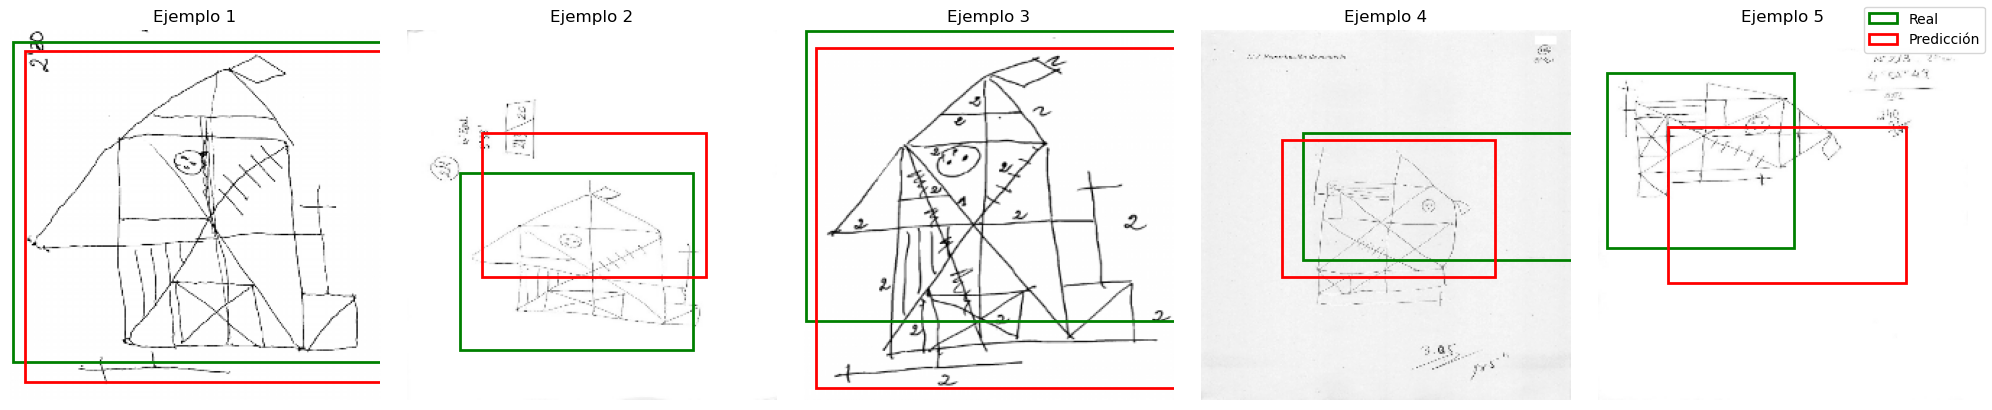

In [16]:
eval_visual_test(modelo_bbox, test_dataset)

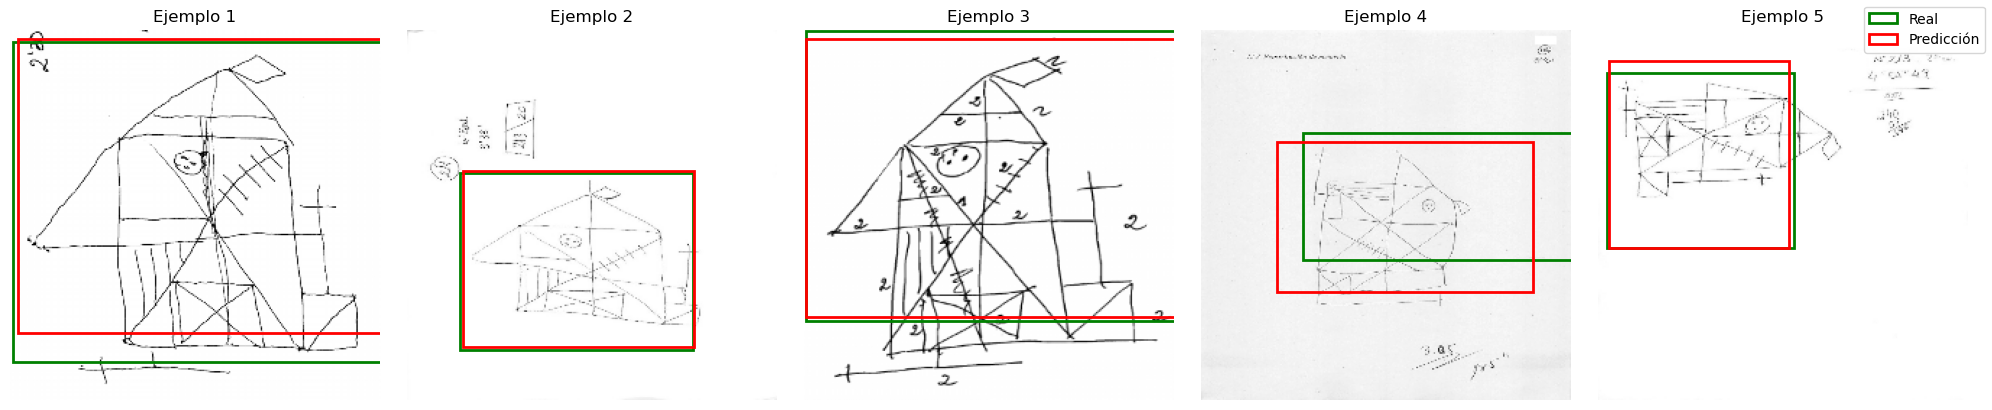

In [17]:
eval_visual_test(resnet18, test_dataset, adjust=True)

In [18]:
eval_IOU_test(modelo_bbox, test_dataset)

IoU promedio en test (50 muestras): 0.4807


In [21]:
eval_IOU_test(resnet18, test_dataset, adjust=True)

IoU promedio en test (50 muestras): 0.7727
